In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import requests
import bs4
import textblob
import pathlib
from bs4 import BeautifulSoup
import time
import os
import glob
from datetime import datetime
from nltk import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA, TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import random
import re
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import time


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def clean_newsletters_MB(newsletters_df):

    # Define a function to filter out websites and replace numbers
    def filter_websites_and_numbers(text):
        # Filter out websites
        pattern_website = r'(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z][a-z\-]*'
        text = re.sub(pattern_website, '', text)

        # Replace numbers with a 'num' tag (except 4-digit numbers)
        text = re.sub(r'\b\d{1,3}\b', 'num', text)
        return text

    # Apply the function to the 'paragraphs' column
    newsletters_df['paragraphs'] = newsletters_df['paragraphs'].apply(lambda x: [filter_websites_and_numbers(paragraph) for paragraph in x])

    # Define a function to remove text after the specified keyword in a single paragraph
    def remove_text_after_keyword(paragraph, keyword):
        for idx, text in enumerate(paragraph):
            if keyword in text:
                paragraph[idx] = text.split(keyword)[0]
        return paragraph

    filter_keywords = ['Share Morning Brew with your friends']

    # Apply the function to the 'paragraphs' column
    newsletters_df['paragraphs'] = newsletters_df['paragraphs'].apply(lambda x: remove_text_after_keyword(x, keyword) for keyword in filter_keywords)

    newsletters_df['title'] = newsletters_df['title'].str.replace(r'\s*\| Morning Brew', '', regex=True)

    filter_keywords = ['PRESENTED BY', 'TOGETHER WITH', 'SPONSORED BY']
    newsletters_df['paragraphs'] = newsletters_df['paragraphs'].apply(lambda x: '\n'.join([paragraph for paragraph in x if all(keyword not in paragraph for keyword in filter_keywords)]))

    # insert column label for the newsletter type
    newsletters_df.insert(0, 'newsletter', 'MB')

In [5]:
def clean_newsletters_NYT(newsletters_df):

     # Define a function to filter out websites and replace numbers
    def filter_websites_and_numbers(text):
        # Filter out websites
        pattern_website = r'(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z][a-z\-]*'
        text = re.sub(pattern_website, '', text)

        # Replace numbers with a 'num' tag (except 4-digit numbers)
        text = re.sub(r'\b\d{1,3}\b', 'num', text)
        return text

    # Apply the function to the 'paragraphs' column
    newsletters_df['paragraphs'] = newsletters_df['paragraphs'].apply(lambda x: [filter_websites_and_numbers(paragraph) for paragraph in x])

    filter_keywords = ['Sign up here to get this newsletter in your inbox']

    # Define a function to remove text after the specified keyword in a single paragraph
    def remove_text_after_keyword(paragraph, keyword):
        for idx, text in enumerate(paragraph):
            if keyword in text:
                paragraph[idx] = text.split(keyword)[0]
        return paragraph

    # Apply the function to the 'paragraphs' column
    newsletters_df['paragraphs'] = newsletters_df['paragraphs'].apply(lambda x: remove_text_after_keyword(x, keyword) for keyword in filter_keywords)

    newsletters_df['title'] = newsletters_df['title'].str.replace(r'\s*\ - The New York Times', '', regex=True)

    filter_keywords = ['Advertisement', 'Newsletter','Supported by']
    newsletters_df['paragraphs'] = newsletters_df['paragraphs'].apply(lambda x: '\n'.join([paragraph for paragraph in x if all(keyword not in paragraph for keyword in filter_keywords)]))

    # insert column label for the newsletter type
    newsletters_df.insert(0, 'newsletter', 'NYT')

In [6]:
# local file read
def html_parser_from_local_html_text(text_file_path):

    all_data_local = []

    def date_style(tag):
        return tag.name == 'td' and tag.get('style') == 'font-family: Arial, Helvetica, sans-serif; font-size: 12px;color:#000000; '

    def bullet_points_style(tag):
        return tag.name == 'li' and tag.get('style') == 'line-height:22px;margin-bottom:10px'

    # Read the list of HTML content from the text file
    with open(text_file_path, 'r') as file:
        html_snippets = file.read().split('zulu')  # Assuming each snippet is separated by 'zulu'

    for html_content in html_snippets:
        soup = BeautifulSoup(html_content, 'html.parser')
        # Get title
        title = soup.title.text.strip()

        # Get dates
        dates_element = soup.find_all(date_style)
        date_texts = [date.text.strip() for date in dates_element]
        date_texts = [date.replace('[', '').replace(']', '') for date in date_texts]

        # Convert date strings to datetime objects
        date_objects = []
        for date_text in date_texts:
            date_obj = datetime.strptime(date_text, "%B %d, %Y")
            date_objects.append(date_obj)

        # Get paragraphs
        paragraphs = soup.find_all(['p', bullet_points_style])
        paragraph_texts = [p.text.strip() for p in paragraphs]

        # Get authors
        author_paragraphs = soup.find_all('p', style='line-height:22px;margin-top:0;margin-bottom:15px')

        # Get authors from the first occurrence in each paragraph
        authors = []
        for author_paragraph in author_paragraphs:
            paragraph_text = author_paragraph.get_text().strip()
            if paragraph_text.startswith("—"):
                em_tag = author_paragraph.find_next('em')
                if em_tag:
                    authors.extend([name.strip() for name in paragraph_text[1:].split(',')])
                    break
            else:
                em_tags = author_paragraph.find_all('em')
                for em_tag in em_tags:
                    em_text = em_tag.get_text().strip()
                    if em_text.startswith("—") or em_text.startswith("-"):
                        authors.extend([name.strip() for name in em_text[1:].split(',')])
                        break

        # Dictionary with data for each URL
        url_data = {
            'title': title,
            'date': date_obj.strftime('%Y-%m-%d'),
            'authors': authors,
            'paragraphs': paragraph_texts
        }

        # Append data to the list
        all_data_local.append(url_data)

    return all_data_local

# Example usage:
local_text_file_path = '/content/drive/MyDrive/Fourth Year/newsletter sentiment analysis/morning_brew_json.txt'
parsed_data = html_parser_from_local_html_text(local_text_file_path)

In [7]:
local_MB_df = pd.DataFrame(parsed_data)

In [8]:
# clean the newsletter dataframe
clean_newsletters_MB(local_MB_df)

# print the newsletter dataframe
local_MB_df

,newsletter,title,date,authors,paragraphs
0,MB,Duty free,2023-10-11,"[Molly Liebergall, Matty Merritt, Sam Klebanov...",\nGood morning. In today’s edition:\nHow Hamas...
1,MB,Spidey-Senses,2023-10-10,"[Sam Klebanov, Cassandra Cassidy, Molly Lieber...","\nGood morning. Today is num/num, the climax o..."
2,MB,The outbreak of war,2023-10-09,"[Neal Freyman, Dave Lozo]",\nGood morning. Today is Columbus Day and Indi...
3,MB,Regicidal chatbot,2023-10-07,"[Molly Liebergall, Sam Klebanov, Matty Merritt...",\nGood morning. It’s the Saturday of a three-d...
4,MB,Greased Alaska,2023-10-06,"[Matty Merritt, Molly Liebergall, Cassandra Ca...",\nGood morning. For all the new managers in th...
...,...,...,...,...,...
300,MB,Sacrifice,2022-10-15,"[Neal Freyman, Matty Merritt, Abby Rubenstein,...",\nGood morning on this beautiful fall weekend....
301,MB,"Netflix, with ads",2022-10-14,"[Neal Freyman, Max Knoblauch, Matty Merritt]",\nGood morning. Tim Urban of Wait But Why pose...
302,MB,Pay up,2022-10-13,"[Neal Freyman, Abby Rubenstein, Matty Merritt]",\nGood morning. There may not have been a drin...
303,MB,Dunkin' revolt,2022-10-12,"[Abby Rubenstein, Max Knoblauch, Neal Freyman]","\nGood morning. Today, num/num/num, is one of ..."


In [9]:
def NYT_html_parser_from_local_html_text(text_file_path):
    # Read the HTML content from the text file
    with open(text_file_path, 'r') as file:
        html_content = file.read()

    # Parse the HTML content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Get title
    title = soup.title.text.strip()

    def has_data_testid(tag):
        return tag.has_attr('data-testid') and tag['data-testid'] == 'onsite-timestamp'

    def has_class_css3xqm5e(tag):
        return tag.has_attr('class') and 'css-3xqm5e' in tag['class']

    # Find the element based on the custom filter function
    date_element = soup.find(has_class_css3xqm5e)

    # Check if a date element was found
    if date_element:
        # Extract the date text
        date_text = date_element.find('time')['datetime'][:10]
    else:
        date_text = "Date not found"

    # Get author name
    author_element = soup.find('span', class_='css-1baulvz last-byline')
    if author_element and author_element.find('a'):
        author_name = author_element.find('a').text.strip()
    else:
        # If author name is not found in the first structure, check the secondary structure
        secondary_author_element = soup.find('span', class_='css-1baulvz last-byline', itemprop='name')
        author_name = secondary_author_element.text.strip() if secondary_author_element else "Author not found"

    # Get paragraphs
    paragraphs = soup.find_all('p')
    paragraph_texts = [p.text.strip() for p in paragraphs]

    # Create a dictionary with the data
    url_data = {
        'title': title,
        'date': date_text,
        'authors': author_name,
        'paragraphs': paragraph_texts
    }

    return url_data

In [10]:
NYT_folder_path = '/content/drive/MyDrive/Fourth Year/newsletter sentiment analysis/NYT'

file_extension = '*'

file_paths = glob.glob(os.path.join(NYT_folder_path, file_extension))

NYT_data = []

# Process each file and accumulate the data in all_data_local
for file_path in file_paths:
    data = NYT_html_parser_from_local_html_text(file_path)
    NYT_data.append(data)  # Append to the list with dictionaries

local_NYT_df = pd.DataFrame(NYT_data)

In [11]:
local_NYT_df = local_NYT_df.sort_values(by='date', ascending = False)
clean_newsletters_NYT(local_NYT_df)

In [12]:
local_NYT_df

,newsletter,title,date,authors,paragraphs
0,NYT,Hamas’s Hostages,2023-10-11,Lauren Jackson,The scale of the hostage situation in the Gaza...
1,NYT,The Nation’s Top-Performing Public School System,2023-10-10,David Leonhardt,Schools run by the Defense Department educate ...
2,NYT,The Global Context of the Hamas-Israel War,2023-10-09,David Leonhardt,The Hamas attack is a sign of a new world orde...
3,NYT,A Surprise Attack on Israel,2023-10-08,Steven Erlanger,Israel says it is at war with Gaza.\nBy Steven...
4,NYT,Meet the Plant People,2023-10-07,Melissa Kirsch,"For some, tending to our humble home gardens, ..."
...,...,...,...,...,...
359,NYT,Dressing Up,2022-10-15,Melissa Kirsch,As the seasons change and more people return t...
360,NYT,Herschel Walker’s Polling Dip,2022-10-14,Nate Cohn,How the Senate race in Georgia is shaking out....
361,NYT,What Happened to Monkeypox?,2022-10-13,German Lopez,Why cases suddenly began to decline.\nBy Germa...
362,NYT,Abortion Bans Weigh on Republicans,2022-10-12,Lisa Lerer,Banning abortion is weighing on the party.\nBy...


In [13]:
combined_datasets = pd.concat([local_NYT_df, local_MB_df], axis=0)

In [14]:
# Shuffling rows within the dataset to mitigate any effects of concatenation
combined_datasets = combined_datasets.sample(frac=1, random_state=42).reset_index(drop=True)
combined_datasets.head(12)

,newsletter,title,date,authors,paragraphs
0,NYT,Herschel Walker’s Polling Dip,2022-10-14,Nate Cohn,How the Senate race in Georgia is shaking out....
1,NYT,It’s Coronation Day,2023-05-06,Melissa Kirsch,Come for the crown jewels and gold stagecoach;...
2,MB,Abercrombie is back,2023-05-25,"[Molly Liebergall, Matty Merritt, Cassandra Ca...",\nGood morning. If you thought you were gettin...
3,MB,They got 50,2022-11-14,[Neal Freyman],\nGood morning. If you’re looking for a distra...
4,NYT,Brazil and Jan. 6,2023-01-10,German Lopez,How Brazil’s riots compare to the Jan. num att...
5,NYT,What Happened to Monkeypox?,2022-10-13,German Lopez,Why cases suddenly began to decline.\nBy Germa...
6,NYT,A Clash of Rights,2022-12-06,German Lopez,The Supreme Court will decide a case over gay ...
7,NYT,History in the Rubble,2023-03-26,Ashley Wu,Documenting the damage of last month’s earthqu...
8,MB,Breaking the seal,2023-04-05,"[Sam Klebanov, Matty Merritt, Neal Freyman]",\nGood morning and Happy Passover to all those...
9,NYT,Compounding Disasters,2023-07-13,German Lopez,America’s compounding natural disasters show t...


In [15]:
# Convert the 'date' column to datetime format
combined_datasets['date'] = pd.to_datetime(combined_datasets['date'])

# Create a new column 'month' with the month number
combined_datasets['month'] = combined_datasets['date'].apply(lambda x: x.month)

# Display the updated DataFrame
combined_datasets

,newsletter,title,date,authors,paragraphs,month
0,NYT,Herschel Walker’s Polling Dip,2022-10-14,Nate Cohn,How the Senate race in Georgia is shaking out....,10
1,NYT,It’s Coronation Day,2023-05-06,Melissa Kirsch,Come for the crown jewels and gold stagecoach;...,5
2,MB,Abercrombie is back,2023-05-25,"[Molly Liebergall, Matty Merritt, Cassandra Ca...",\nGood morning. If you thought you were gettin...,5
3,MB,They got 50,2022-11-14,[Neal Freyman],\nGood morning. If you’re looking for a distra...,11
4,NYT,Brazil and Jan. 6,2023-01-10,German Lopez,How Brazil’s riots compare to the Jan. num att...,1
...,...,...,...,...,...,...
665,NYT,A Closer Look at the Registered Voters Who Don...,2023-08-01,David Leonhardt,Looking more closely at the registered voters ...,8
666,NYT,115 Degrees Fahrenheit,2023-06-27,German Lopez,"Summer technically just began, and parts of th...",6
667,NYT,Cinema Studies,2023-01-15,Melissa Kirsch,Awards season has begun. It’s time to cram.\nB...,1
668,MB,Ice cream so good,2023-07-20,"[Cassandra Cassidy, Matty Merritt, Molly Liebe...",\nGood morning. Our inbox was a house divided ...,7


In [16]:
from transformers import DistilBertTokenizerFast
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel
import torch.nn as nn
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.nn.utils.clip_grad import clip_grad_norm_
from transformers import Trainer, TrainingArguments

In [17]:
model_name = 'distilbert-base-cased'

# Create tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

# Create tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [18]:
combined_datasets['date'] = combined_datasets['date'].dt.strftime('%Y-%m-%d')

In [19]:
def generate_chunks(paragraphs, newsletter_types, dates, chunk_size=200):
    chunks = []
    chunk_newsletter_types = []
    chunk_dates = []

    for i in range(len(paragraphs)):
        text = paragraphs.iloc[i]  # Extract the text from the Series
        newsletter_type = newsletter_types.iloc[i]
        date = dates.iloc[i]

        # Split the text into paragraphs using '\n'
        text_paragraphs = text.split('\n')

        current_chunk = []
        current_chunk_newsletter_types = []

        for paragraph in text_paragraphs:
            # Check if the length of the paragraph exceeds the chunk size
            if len(paragraph) > chunk_size:
                chunks.append(paragraph)
                chunk_newsletter_types.append(newsletter_type)
                chunk_dates.append(date)
            else:
                # If not, add the paragraph to the current chunk
                current_chunk.append(paragraph)
                current_chunk_newsletter_types.append(newsletter_type)

                # Check if the current chunk size exceeds the specified limit
                if len(' '.join(current_chunk)) > chunk_size:
                    chunks.append(' '.join(current_chunk))
                    chunk_dates.extend([date])
                    chunk_newsletter_types.append(newsletter_type)
                    current_chunk = []
                    current_chunk_newsletter_types = []

        # Add any remaining paragraphs to the last chunk
        if current_chunk:
            chunks.append(' '.join(current_chunk))
            chunk_dates.extend([date])
            chunk_newsletter_types.append(newsletter_type)

    return chunks, chunk_newsletter_types, chunk_dates

# Generate chunks
result_chunks, newsletter_types_chunked, dates_chunked = generate_chunks(combined_datasets['paragraphs'], combined_datasets['newsletter'], combined_datasets['date'])

# Convert NYT and MB into binary representation
for i in range(len(newsletter_types_chunked)):
    if newsletter_types_chunked[i] == 'NYT':
        newsletter_types_chunked[i] = 1
    else:
        newsletter_types_chunked[i] = 0

In [20]:
# Convert date types into an integer representation
reference_date = datetime(2022, 10, 11)
date_integers_chunked = [(datetime.strptime(date_str, "%Y-%m-%d") - reference_date).days for date_str in dates_chunked]

In [21]:
# Create tokenizer
encoded_corpus = tokenizer(text=result_chunks,
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)

input_ids = encoded_corpus['input_ids']
attention_mask = encoded_corpus['attention_mask']

In [22]:
test_size = 0.1
validation_size = 0.2
seed = 42
labels = date_integers_chunked

# Initial split into training/testing sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, test_size=test_size, random_state=seed)
train_masks, test_masks, _, _ = train_test_split(attention_mask, labels, test_size=test_size, random_state=seed)

# Further split the testing set into testing and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels, test_size=validation_size, random_state=seed)
train_masks, validation_masks, _, _ = train_test_split(train_masks, train_masks, test_size=validation_size, random_state=seed)

# Convert labels to NumPy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
validation_labels = np.array(validation_labels)

In [23]:
date_scaler = StandardScaler()
date_scaler.fit(train_labels.reshape(-1, 1))

train_labels = date_scaler.transform(train_labels.reshape(-1, 1))
test_labels = date_scaler.transform(test_labels.reshape(-1, 1))
validation_labels = date_scaler.transform(validation_labels.reshape(-1, 1))

In [24]:
# Create dataloaders
batch_size = 32

def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs, dtype=torch.float32)
    mask_tensor = torch.tensor(masks, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(input_tensor, mask_tensor,
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True)
    return dataloader

train_dataloader = create_dataloaders(train_inputs, train_masks, train_labels, batch_size)
test_dataloader = create_dataloaders(test_inputs, test_masks, test_labels, batch_size)
val_dataloader = create_dataloaders(validation_inputs, validation_masks, validation_labels, batch_size)

In [25]:
class BertRegressor(nn.Module):

    def __init__(self, drop_rate=0.2):

        super(BertRegressor, self).__init__()
        D_in, D_out = 768, 1  # Assuming you want a single regression output

        self.bert = \
            BertModel.from_pretrained('bert-base-uncased')

        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_out))

    def forward(self, input_ids, attention_masks):

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_masks)
        pooled_output = outputs['pooler_output']
        outputs = self.regressor(pooled_output)
        return outputs

# Create an instance of the model
model = BertRegressor(drop_rate=0.2)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [26]:
device = torch.device('cuda')

model.to(device)

BertRegressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [27]:
# Adam optimizer
optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                 num_warmup_steps=0, num_training_steps=total_steps)

In [29]:
loss_function = nn.MSELoss()

In [30]:
def train(model, optimizer, scheduler, loss_function, epochs,
          train_dataloader, device, clip_value=2):
    for epoch in range(epochs):
        print(epoch)
        print("-----")
        best_loss = 1e10
        model.train()
        for step, batch in enumerate(train_dataloader):
            batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)

            batch_inputs = batch_inputs.to(torch.long)  # Convert input_ids to torch.long

            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)
            loss = loss_function(outputs.squeeze(),
                             batch_labels.squeeze())
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()

    return model

model = train(model, optimizer, scheduler, loss_function, epochs, train_dataloader, device, clip_value=2)

0
-----
1
-----
2
-----
3
-----
4
-----


In [31]:
def evaluate(model, loss_function, test_dataloader, device):
    model.eval()
    test_loss, test_r2 = [], []
    for batch in test_dataloader:
        batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)

        batch_inputs = batch_inputs.to(torch.long)  # Convert input_ids to torch.long

        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
        loss = loss_function(outputs, batch_labels)
        test_loss.append(loss.item())
        r2 = r2_score(outputs, batch_labels)
        test_r2.append(r2.item())
    return test_loss, test_r2

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [32]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, _ = \
                                  tuple(b.to(device) for b in batch)

        batch_inputs = batch_inputs.to(torch.long)  # Convert input_ids to torch.long

        with torch.no_grad():
            output += model(batch_inputs,
                            batch_masks).view(1,-1).tolist()[0]
    return output

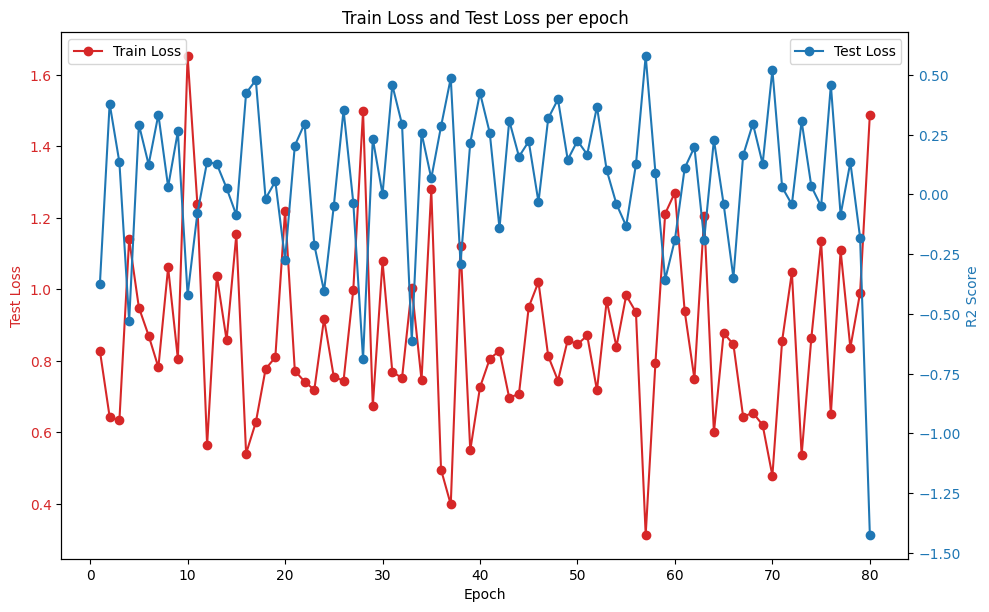

In [33]:
def plot_metrics(test_losses, test_r2_scores):
    epochs = range(1, len(test_losses) + 1)

    # Plot Loss and R2 score per epoch
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Test Loss', color=color)
    ax1.plot(epochs, test_losses, label='Train Loss', marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('R2 Score', color=color)
    ax2.plot(epochs, test_r2_scores, label='Test Loss', marker='o', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.title('Train Loss and Test Loss per epoch')
    plt.show()

# Example usage
train_losses, test_losses = evaluate(model, loss_function, test_dataloader, device)
plot_metrics(train_losses, test_losses)


In [36]:
# Testing on validation set
y_pred_scaled = predict(model, val_dataloader, device)
y_test = validation_labels
y_pred_scaled_array = np.array(y_pred_scaled)
y_pred = date_scaler.inverse_transform(y_pred_scaled_array.reshape(-1, 1))


In [41]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
#mdape = ((pd.Series(y_test) - pd.Series(y_pred))\
         #/ pd.Series(y_test)).abs().median()
r_squared = r2_score(y_test, y_pred)

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'MDAE', 'MSE', 'MAPE', 'R^2'],
    'Value': [mae, mdae, mse, mape, r_squared]
})

# Print the DataFrame
print(metrics_df)

  Metric         Value
0    MAE    188.220820
1   MDAE    191.971616
2    MSE  41537.787152
3   MAPE    819.440655
4    R^2 -41393.686027
